In [1]:
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score

from influxdb.commands import InfluxDBQueries, DataProcessor
import pandas as pd
import pickle
tf.config.set_visible_devices([], 'GPU')

In [2]:
columns_5m = ['volume', 'return_1', 'return_5', 'return_mean_24', 'return_std_24', 'ma_diff', 'rsi_14', 'macd', 'macd_signal', 'macd_hist', 'stoch_k', 'stoch_d', 'obv', 'market_return', 'expected_return', 'actual_return']
columns_1h = ['tb_base', 'tb_quote', 'close', 'quote_volume', 'return_1', 'return_5', 'return_mean_24', 'ma_diff', 'rsi_14', 'macd', 'macd_signal', 'macd_hist', 'stoch_k', 'stoch_d', 'obv', 'price', 'market_return', 'expected_return', 'actual_return', 'alpha']
columns_1d = ['return_1', 'return_5', 'rsi_14', 'bb_lower', 'bb_width', 'obv', 'range_pct', 'actual_return']

In [3]:
model_5m = tf.keras.models.load_model('./models/cnn_lstm_5m.keras')

In [4]:
model_1h = tf.keras.models.load_model('./models/cnn_lstm_1h.keras')

In [5]:
model_1d = tf.keras.models.load_model('./models/cnn_lstm_1d.keras')

In [6]:
scaler_5m = pickle.load(open('./scalers/scaler5m.pkl', 'rb'))
scaler_1h = pickle.load(open('./scalers/scaler1h.pkl', 'rb'))
scaler_1d = pickle.load(open('./scalers/scaler1d.pkl', 'rb'))

In [7]:
model_5m.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 288, 64)        │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 288, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 288, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 288, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 288, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 288, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 288, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 80)             │        66,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 508,917 (1.94 MB)

 Trainable params: 169,457 (661.94 KB)

 Non-trainable params: 544 (2.12 KB)

 Optimizer params: 338,916 (1.29 MB)

In [8]:
df_train = InfluxDBQueries.get_data_from_influx(groupby_time='5m', pair='BTCUSDT', start="2021-01-01T01:00:00Z",
                                                stop="2025-01-01T01:00:00Z")
df_val = InfluxDBQueries.get_data_from_influx(groupby_time='5m', pair='BTCUSDT', start="2025-01-01T01:00:00Z",
                                              stop="2025-03-01T01:00:00Z")
df_test = InfluxDBQueries.get_data_from_influx(groupby_time='5m', pair='BTCUSDT', start="2025-03-01T01:00:00Z",
                                               stop="2025-04-20T01:00:00Z")
df_combined = pd.concat([df_train, df_test, df_val])

In [9]:
df_combined, scaler, columns, sclaer_y = DataProcessor.add_features(df_combined, classification=True, group_time='5m', scaler=scaler_5m, boruta_columns=columns_5m, target_shift=1)

Index(['low', 'trades', 'tb_quote', 'volume', 'high', 'close', 'quote_volume',
       'tb_base', 'open', 'return_1', 'return_5', 'close_ma_24',
       'close_std_24', 'return_mean_24', 'return_std_24', 'range_24',
       'vol_mean_24', 'vol_std_24', 'sma_fast', 'sma_slow', 'ma_diff',
       'rsi_14', 'macd', 'macd_signal', 'macd_hist', 'stoch_k', 'stoch_d',
       'tr', 'atr_14', 'bb_mid', 'bb_std', 'bb_upper', 'bb_lower', 'bb_width',
       'vwap', 'obv', 'range_cur', 'range_pct', 'close_moving_avg', 'price',
       'beta', 'market_return', 'expected_return', 'actual_return', 'alpha',
       'risk_free_rate', 'target'],
      dtype='object')


/Users/gaszneradam/Documents/BME/6_felev/onlab/befektetesi_portfolio_elemzes/influxdb/commands/data_processors.py:149: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.54393087 -0.41505305 -0.38558512 ...  0.09397885  0.36256307
  0.06193691]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, scaler.feature_names_in_] = scaler.transform(df.loc[:, scaler.feature_names_in_])


In [10]:
df_combined.dropna(inplace=True)

In [11]:
df_test = df_combined.loc[
    df_combined.index.strftime('%Y-%m-%dT%H:%M:%SZ') >= df_test.index[0].strftime('%Y-%m-%dT%H:%M:%SZ')]
df_test = df_test.dropna()

In [12]:
df_test

,low,trades,tb_quote,volume,high,close,quote_volume,tb_base,open,return_1,...,range_pct,close_moving_avg,price,beta,market_return,expected_return,actual_return,alpha,risk_free_rate,target
time,,,,,,,,,,,,,,,,,,,,,
2025-03-01 01:05:00+00:00,1.038438,0.312326,-0.178802,-0.370860,1.036671,1.040089,-0.209969,-0.338705,1.035034,-69.256041,...,-0.132298,1.395547,1.040089,0.816691,-0.153433,-0.196460,-0.205859,-0.094793,0.0,1
2025-03-01 01:10:00+00:00,1.040102,0.100902,-0.409932,-0.466843,1.040262,1.038866,-0.340823,-0.509062,1.040100,-0.220976,...,0.179698,1.325516,1.038866,0.815620,-0.101794,-0.133186,-0.148240,-0.084542,0.0,1
2025-03-01 01:15:00+00:00,1.042541,-0.097563,-0.322853,-0.481778,1.038941,1.040840,-0.361140,-0.445012,1.038877,0.345120,...,-0.426867,1.255983,1.040840,0.815602,-0.098127,-0.128694,-0.143248,-0.081709,0.0,1
2025-03-01 01:20:00+00:00,1.044518,-0.219162,-0.430906,-0.478728,1.040163,1.043667,-0.356809,-0.524601,1.040851,0.495984,...,-0.548145,1.186267,1.043667,0.817085,0.093418,0.105990,-0.060785,-0.350215,0.0,1
2025-03-01 01:25:00+00:00,1.044695,-0.100048,-0.357394,-0.509815,1.042414,1.043267,-0.399305,-0.470551,1.043679,-0.075266,...,-0.213614,1.114502,1.043267,0.825591,0.281548,0.337257,0.075910,-0.485346,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-20 00:40:00+00:00,1.093479,-0.406177,-0.526005,-0.596442,1.088200,1.090070,-0.515721,-0.595658,1.090978,-0.160922,...,-0.682571,1.091403,1.090070,-0.610011,0.518788,0.414918,0.266732,-0.192258,0.0,1
2025-04-20 00:45:00+00:00,1.091586,-0.419491,-0.556019,-0.642655,1.086462,1.088127,-0.579837,-0.617397,1.090081,-0.343680,...,-0.658570,1.090817,1.088127,-0.614672,0.481717,0.382164,0.237659,-0.195804,0.0,1
2025-04-20 00:50:00+00:00,1.090538,-0.408751,-0.492754,-0.594170,1.085732,1.087973,-0.512701,-0.571445,1.088139,-0.031429,...,-0.608290,1.090202,1.087973,-0.615441,0.485258,0.385119,0.245615,-0.183027,0.0,1


In [13]:
X_test, y_test = DataProcessor.make_sequences(df_test, columns_to_select=columns_5m, window_size=288, forecast_horizon=1, classification=True)

In [14]:
pred = model_5m.predict(X_test)

441/441 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step


In [15]:
pred_adjusted = (pred > 0.5).astype(int)

In [16]:
roc_auc_score(y_test, pred)

0.7522098493387344

In [17]:
print(classification_report(y_test, pred_adjusted))

              precision    recall  f1-score   support

           0       0.72      0.54      0.62      7034
           1       0.64      0.79      0.71      7078

    accuracy                           0.67     14112
   macro avg       0.68      0.67      0.66     14112
weighted avg       0.68      0.67      0.66     14112



In [18]:
df_test.loc[:, scaler_5m.feature_names_in_] = scaler_5m.inverse_transform(df_test.loc[:, scaler_5m.feature_names_in_])

In [19]:
df_test

,low,trades,tb_quote,volume,high,close,quote_volume,tb_base,open,return_1,...,range_pct,close_moving_avg,price,beta,market_return,expected_return,actual_return,alpha,risk_free_rate,target
time,,,,,,,,,,,,,,,,,,,,,
2025-03-01 01:05:00+00:00,83851.86,12110.0,2.448594e+06,56.56409,83981.14,83978.00,4.746645e+06,29.17820,83857.91,-0.110413,...,0.001539,92401.858333,83978.00,0.871422,-0.000008,-0.000007,-0.000011,-0.000004,4.072808e-07,1
2025-03-01 01:10:00+00:00,83891.26,9728.0,1.218921e+06,40.50522,84066.35,83949.01,3.401375e+06,14.51406,83978.00,-0.000345,...,0.002086,90741.855000,83949.01,0.871230,-0.000003,-0.000002,-0.000006,-0.000004,4.072808e-07,1
2025-03-01 01:15:00+00:00,83949.00,7492.0,1.682206e+06,38.00655,84034.99,83995.80,3.192504e+06,20.02740,83949.01,0.000557,...,0.001024,89093.653333,83995.80,0.871227,-0.000002,-0.000002,-0.000005,-0.000003,4.072808e-07,1
2025-03-01 01:20:00+00:00,83995.79,6122.0,1.107337e+06,38.51680,84064.00,84062.82,3.237024e+06,13.17650,83995.80,0.000798,...,0.000811,87441.128333,84062.82,0.871492,0.000017,0.000015,0.000002,-0.000013,4.072808e-07,1
2025-03-01 01:25:00+00:00,84000.00,7464.0,1.498437e+06,33.31571,84117.43,84053.33,2.800134e+06,17.82907,84062.83,-0.000113,...,0.001397,85740.016667,84053.33,0.873015,0.000037,0.000032,0.000014,-0.000018,4.072808e-07,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-20 00:40:00+00:00,85154.96,4015.0,6.013841e+05,18.82227,85204.02,85162.77,1.603294e+06,7.05990,85184.01,-0.000249,...,0.000576,85192.476667,85162.77,0.615970,0.000061,0.000038,0.000030,-0.000008,4.072808e-07,1
2025-04-20 00:45:00+00:00,85110.16,3865.0,4.417035e+05,11.09032,85162.77,85116.71,9.441376e+05,5.18868,85162.76,-0.000541,...,0.000618,85178.595000,85116.71,0.615135,0.000057,0.000035,0.000028,-0.000008,4.072808e-07,1
2025-04-20 00:50:00+00:00,85085.35,3986.0,7.782873e+05,19.20245,85145.45,85113.05,1.634345e+06,9.14414,85116.72,-0.000043,...,0.000706,85164.013333,85113.05,0.614997,0.000058,0.000036,0.000028,-0.000007,4.072808e-07,1


In [20]:
len(y_test)

14112

In [21]:
len(df_test)

14400

In [22]:
df_test.reset_index(inplace=True)

In [23]:
pred_adjusted = pred_adjusted.flatten()

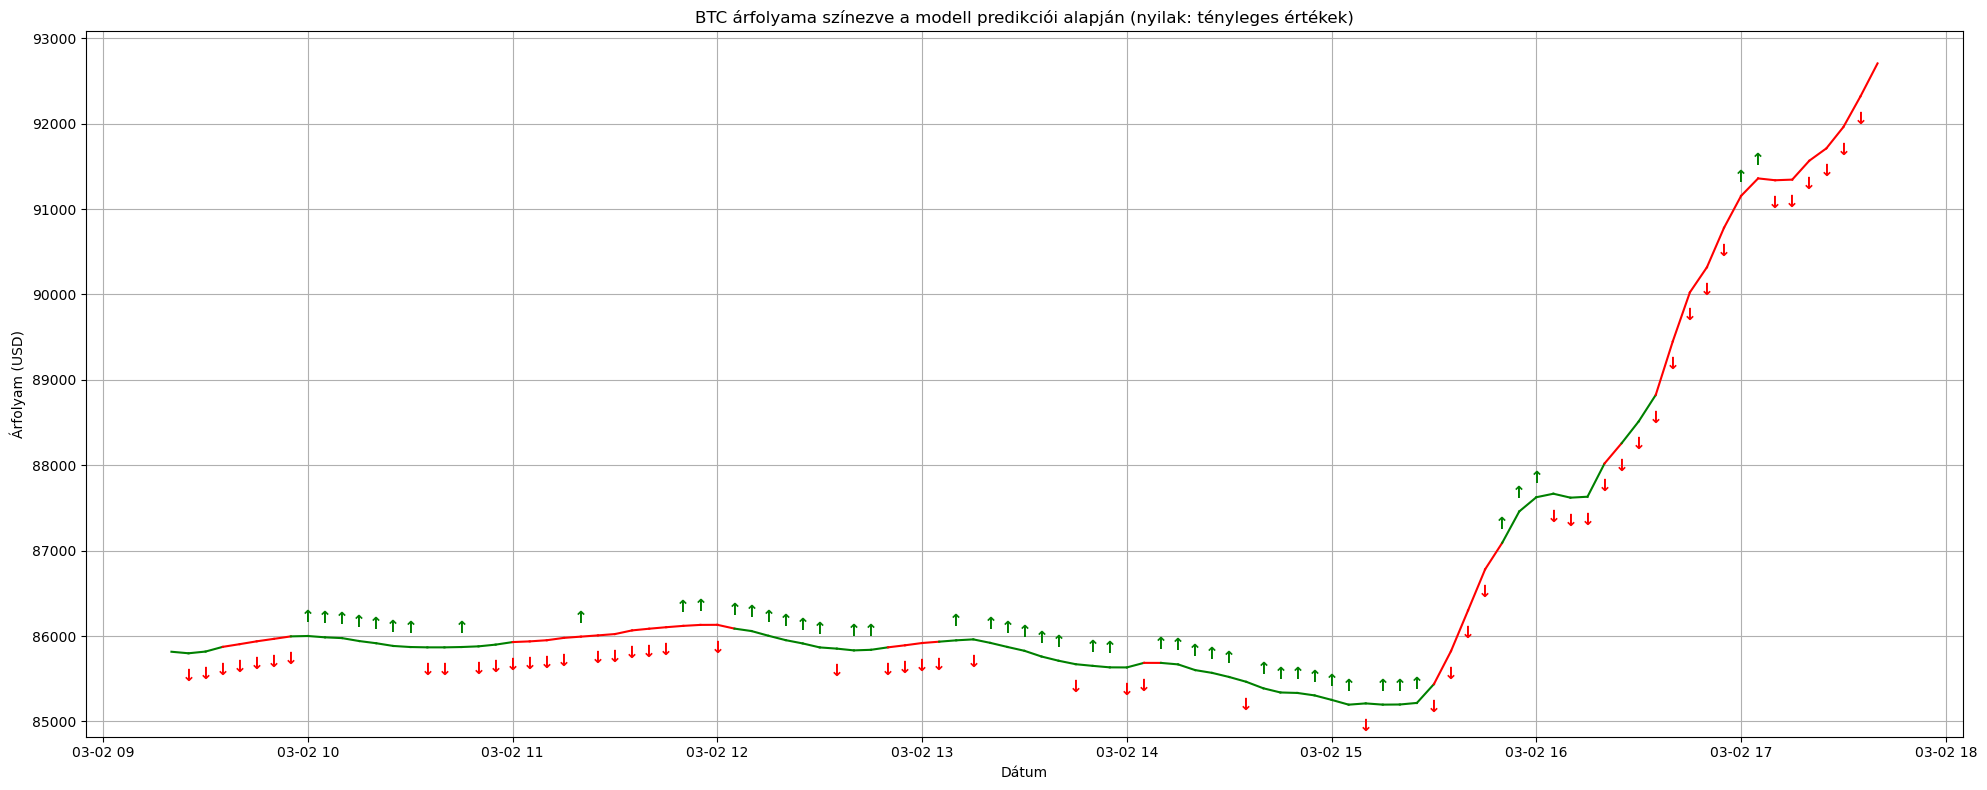

In [35]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 8))

# Időpontok kiválasztása a megfelelő tartományból
time_range = df_test['time'].iloc[388:488]
price_range = df_test['close_moving_avg'].iloc[388:488]
target_values = df_test['target'].iloc[388:488].values

# Árfolyam ábrázolása a predikciók alapján színezve
for i in range(100, 200):
    color = 'green' if pred_adjusted[i] == 1 else 'red'
    plt.plot(df_test['time'].iloc[i-1+288:i+1+288], df_test['close_moving_avg'].iloc[i-1+288:i+1+288], color=color)

# Target értékek jelzése nyilakkal
for i in range(99):
    if target_values[i] == 1:  # Ha a target érték 1, felfelé nyíl
        plt.annotate('↑',
                     xy=(time_range.iloc[i], price_range.iloc[i]),
                     xytext=(0, 10),
                     textcoords='offset points',
                     ha='center',
                     fontsize=12,
                     color='green',
                     weight='bold')
    else:  # Ha a target érték 0, lefelé nyíl
        plt.annotate('↓',
                     xy=(time_range.iloc[i], price_range.iloc[i]),
                     xytext=(0, -20),
                     textcoords='offset points',
                     ha='center',
                     fontsize=12,
                     color='red',
                     weight='bold')

# Jelmagyarázat hozzáadása

plt.title('BTC árfolyama színezve a modell predikciói alapján (nyilak: tényleges értékek)')
plt.xlabel('Dátum')
plt.ylabel('Árfolyam (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

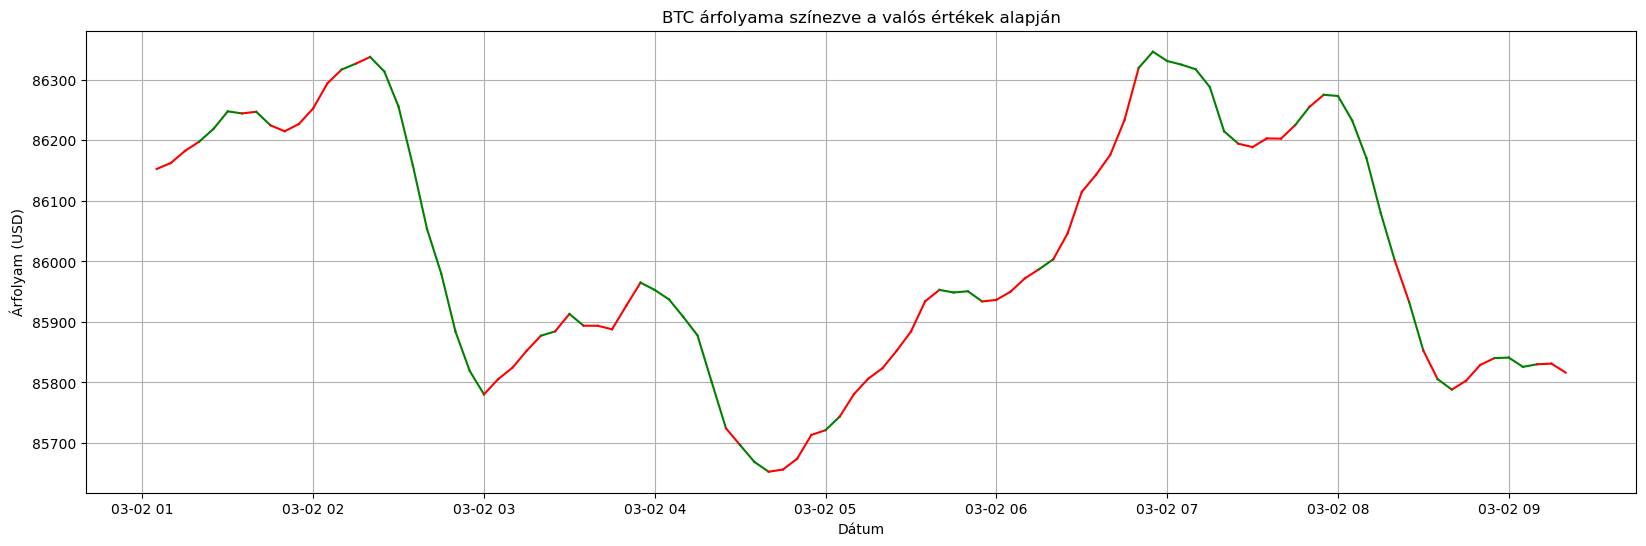

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))

# Feltételezzük, hogy pred_adjusted már flattenelve van, és df_test sorban illeszkedik
for i in range(1, 100):
    color = 'green' if df_test['target'].iloc[i+288] == 1 else 'red'
    plt.plot(df_test['time'].iloc[i-1+288:i+1+288], df_test['close_moving_avg'].iloc[i-1+288:i+1+288], color=color)

plt.title('BTC árfolyama színezve a valós értékek alapján')
plt.xlabel('Dátum')
plt.ylabel('Árfolyam (USD)')
plt.grid(True)
plt.show()
